#  **Data Analytics - Programming Assignment 2**

**Name:** <br>James Matthew C. Garcia <br>
          Rykelle Wei Ruellan<br>
**Course & Year:** BSCS - 2


<hr>

In [34]:
# Load necessary libraries
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Load the med_events_ATC.csv file into a DataFrame
med_events = pd.read_csv("med_events.csv")

# Use pandas styling to display the table cleanly (hiding the index) and limit decimals
table = med_events.head().style\
    .hide(axis="index")\
    .format({"DURATION": "{:.2f}", "PERDAY": "{:.2f}"})\
    .set_table_attributes("class='table table-striped'")

display(table)

PATIENT_ID,DATE,PERDAY,CATEGORY,DURATION
1,04/26/2033,4.00,medA,50.00
1,07/04/2033,4.00,medB,30.00
1,08/03/2033,4.00,medB,30.00
1,08/17/2033,4.00,medB,30.00
1,10/13/2033,4.00,medB,30.00


### **Sessa Empirical Estimator using K-Means**
<hr>

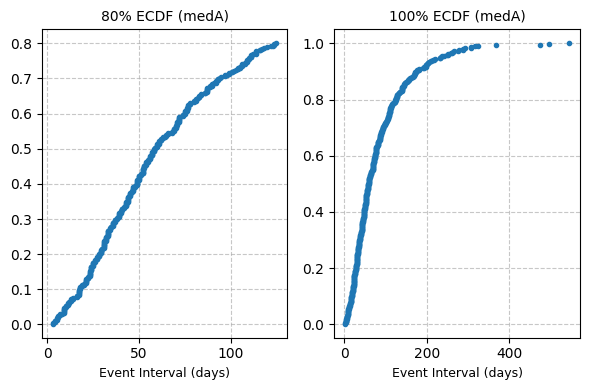

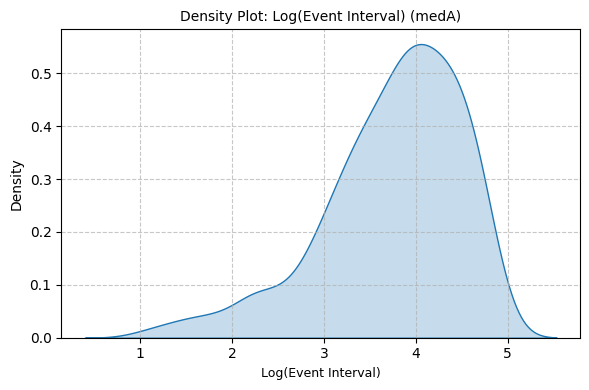

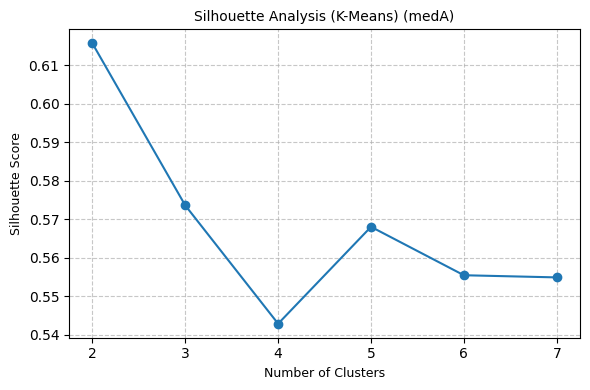

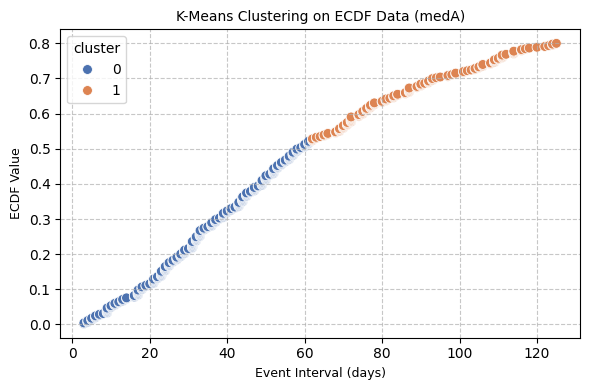

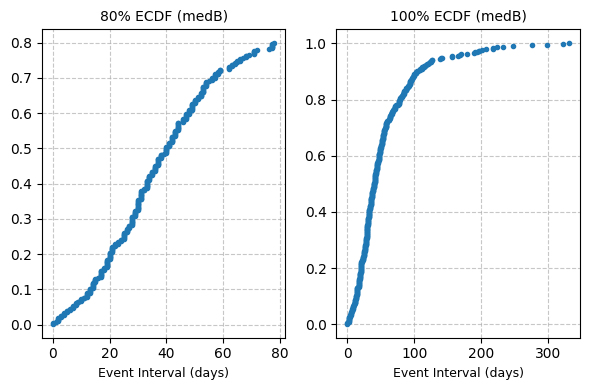

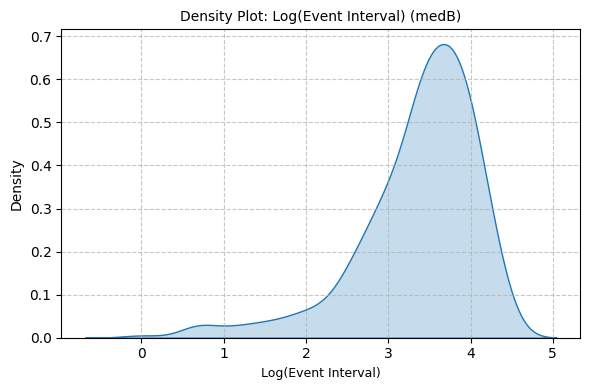

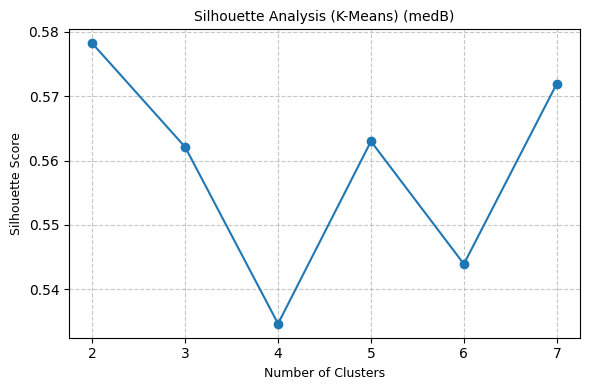

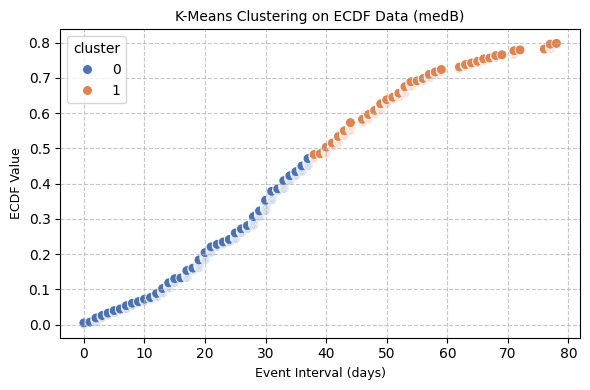

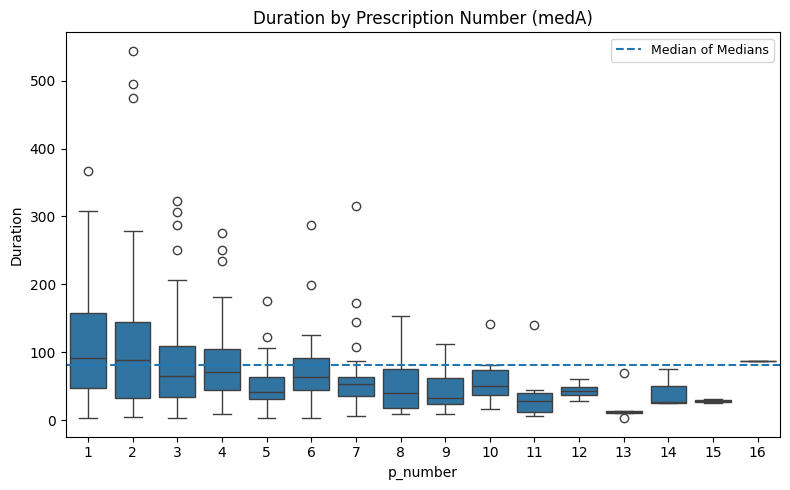

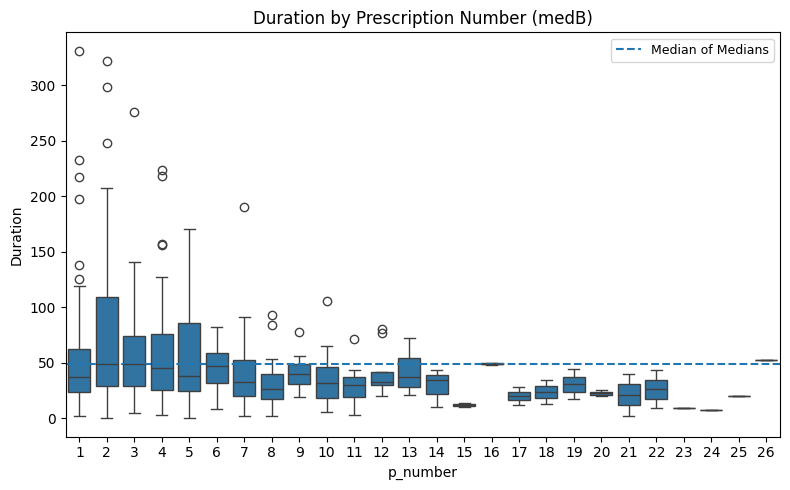

,PATIENT_ID,DATE,PERDAY,CATEGORY,DURATION,prev_date,Duration,p_number
1,1,2033-08-03,4,medB,30,2033-07-04,30.0,1
2,1,2033-08-17,4,medB,30,2033-08-03,14.0,2
3,1,2033-10-13,4,medB,30,2033-08-17,57.0,3
4,1,2033-10-16,4,medB,30,2033-10-13,3.0,4
5,1,2033-11-23,4,medB,30,2033-10-16,38.0,5
...,...,...,...,...,...,...,...,...
508,100,2034-03-05,6,medB,30,2034-01-22,42.0,9
509,100,2034-04-07,6,medB,30,2034-03-05,33.0,10
510,100,2034-04-26,6,medB,30,2034-04-07,19.0,11
511,100,2034-05-26,6,medB,30,2034-04-26,30.0,12


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from statsmodels.distributions.empirical_distribution import ECDF
from datetime import datetime, timedelta
from IPython.display import display

# ------------------------------
# Load simulated data from med_events.csv
# ------------------------------
med_events = pd.read_csv("med_events.csv")
med_events['DATE'] = pd.to_datetime(med_events['DATE'], errors='coerce').dt.date
tidy = med_events.copy()

# ------------------------------
# Function: See (using K-Means)
# ------------------------------
def See(arg1, tidy):
    """
    Processes refill/prescription events for a specific medication (arg1) using K-Means.
    Returns a dictionary with silhouette scores, processed patient data, and cluster summary.
    """
    # Filter data by medication code in CATEGORY column
    data_med = tidy[tidy['CATEGORY'] == arg1].copy()
    if data_med.empty:
        raise ValueError(f"No data found for medication {arg1}")
    
    # Sort data by PATIENT_ID and DATE
    data_med = data_med.sort_values(by=['PATIENT_ID', 'DATE'])
    
    # Calculate intervals in days for each patient
    intervals = []
    patient_data_list = []  # to store each patient’s data
    for patient_id in data_med['PATIENT_ID'].unique():
        patient_data = data_med[data_med['PATIENT_ID'] == patient_id]
        if len(patient_data) > 1:
            dates = pd.to_datetime(patient_data['DATE'])
            patient_intervals = np.diff(dates).astype('timedelta64[D]').astype(int)
            intervals.extend(patient_intervals)
            patient_data_list.append(patient_data)
            
    if len(intervals) == 0:
        raise ValueError("No intervals could be calculated. Ensure each patient has at least two prescriptions.")
    
    # Compute the ECDF
    ecdf_x = np.sort(intervals)
    ecdf_y = np.arange(1, len(ecdf_x)+1) / len(ecdf_x)
    dfper = pd.DataFrame({'x': ecdf_x, 'y': ecdf_y})
    # Use only up to the 80th percentile for clustering
    dfper = dfper[dfper['y'] <= 0.8]
    if len(dfper) == 0:
        raise ValueError("No data points remain after filtering for 80% ECDF")
    
    # ------------------------------
    # Plot ECDF and Density with medication label in the title
    # ------------------------------
    plt.figure(figsize=(6,4))
    plt.subplot(1,2,1)
    plt.plot(dfper['x'], dfper['y'], marker=".", linestyle="none")
    plt.xlabel("Event Interval (days)", fontsize=9)
    plt.title(f"80% ECDF ({arg1})", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.subplot(1,2,2)
    plt.plot(ecdf_x, ecdf_y, marker=".", linestyle="none")
    plt.xlabel("Event Interval (days)", fontsize=9)
    plt.title(f"100% ECDF ({arg1})", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(6,4))
    sns.kdeplot(np.log(dfper['x']), shade=True)
    plt.xlabel("Log(Event Interval)", fontsize=9)
    plt.title(f"Density Plot: Log(Event Interval) ({arg1})", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # ------------------------------
    # K-Means Clustering on normalized ECDF x-values
    # ------------------------------
    a = dfper[['x']].copy()
    a = scale(a)
    silhouette_scores = []
    K_range = range(2, 8)
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(a)
        score = silhouette_score(a, labels)
        silhouette_scores.append(score)
    
    plt.figure(figsize=(6,4))
    plt.plot(list(K_range), silhouette_scores, marker='o')
    plt.xlabel("Number of Clusters", fontsize=9)
    plt.ylabel("Silhouette Score", fontsize=9)
    plt.title(f"Silhouette Analysis (K-Means) ({arg1})", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    best_k = np.argmax(silhouette_scores) + 2  # Since K_range starts at 2
    
    kmeans_final = KMeans(n_clusters=best_k, random_state=42)
    dfper['cluster'] = kmeans_final.fit_predict(a)
    
    # Display the clustering result of K-Means
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=dfper, x='x', y='y', hue='cluster', palette='deep', s=50)
    plt.xlabel("Event Interval (days)", fontsize=9)
    plt.ylabel("ECDF Value", fontsize=9)
    plt.title(f"K-Means Clustering on ECDF Data ({arg1})", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Compute cluster summary: min, max, median per cluster
    clust_min = dfper.groupby('cluster')['x'].min().reset_index()
    clust_max = dfper.groupby('cluster')['x'].max().reset_index()
    clust_median = dfper.groupby('cluster')['x'].median().reset_index()
    
    cluster_summary = pd.merge(clust_min, clust_max, on='cluster')
    cluster_summary = pd.merge(cluster_summary, clust_median, on='cluster')
    cluster_summary.columns = ['Cluster', 'Minimum', 'Maximum', 'Median']
    
    final_df = pd.concat(patient_data_list, ignore_index=True)
    
    return {'scores': silhouette_scores, 'data': final_df, 'clusters': cluster_summary}
    
def see_assumption(result, med_label):
    """
    Plots a boxplot of prescription durations using the processed patient data,
    with a title that distinguishes the medication (med_label).
    """
    if not isinstance(result, dict) or 'data' not in result:
        raise TypeError("Expected a dictionary with a 'data' key from See function")
    
    data = result['data']
    data = data.sort_values(by=['PATIENT_ID', 'DATE'])
    data['prev_date'] = data.groupby('PATIENT_ID')['DATE'].shift(1)
    data['Duration'] = data.apply(lambda row: (pd.to_datetime(row['DATE']) - pd.to_datetime(row['prev_date'])).days 
                                  if pd.notnull(row['prev_date']) else np.nan, axis=1)
    data = data.dropna(subset=['Duration'])
    data['p_number'] = data.groupby('PATIENT_ID').cumcount() + 1
    data['p_number'] = data['p_number'].astype('category')
    
    medians_of_medians = data.groupby('PATIENT_ID')['Duration'].median().reset_index()
    
    plt.figure(figsize=(8,5))
    sns.boxplot(x='p_number', y='Duration', data=data)
    plt.axhline(y=medians_of_medians['Duration'].median(), linestyle='--', label='Median of Medians')
    plt.title(f"Duration by Prescription Number ({med_label})", fontsize=12)
    plt.legend(fontsize=9)
    plt.tight_layout()
    plt.show()
    
    return data

# ------------------------------
# Example usage for medA and medB
# ------------------------------
medA_result = See("medA", tidy)


medB_result = See("medB", tidy)


# Analyze the results with the assumption check function (boxplot) with distinct titles
see_assumption(medA_result, "medA")
see_assumption(medB_result, "medB")

### **Sessa Empirical Estimator using DBSCAN**
<hr>

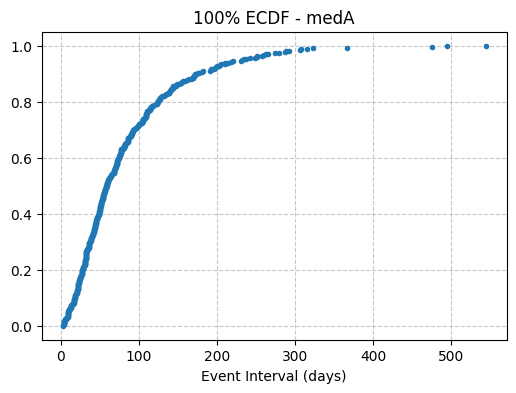

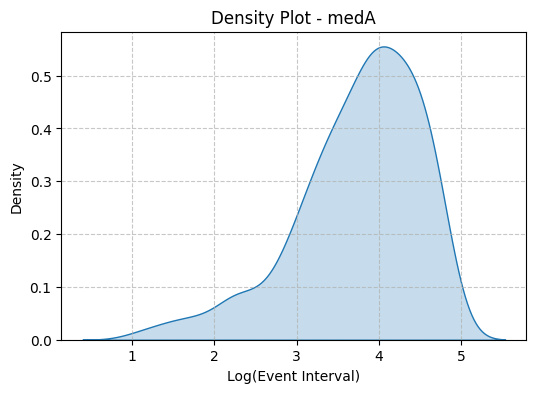

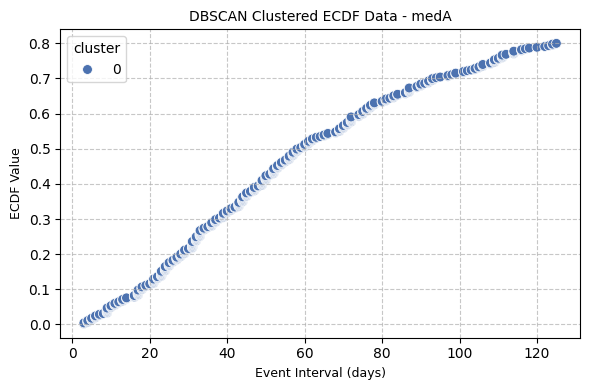

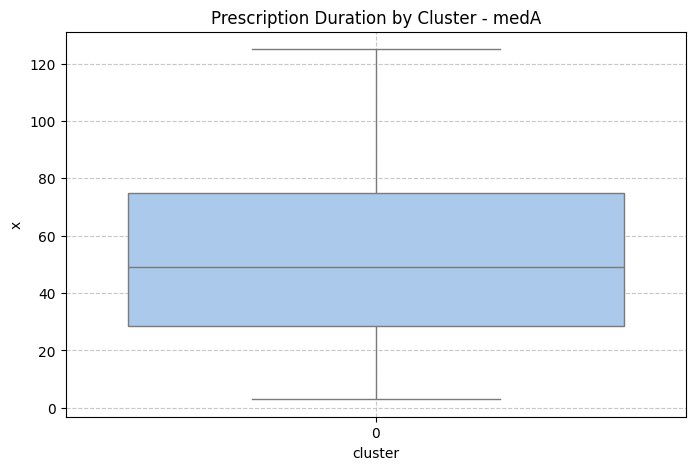

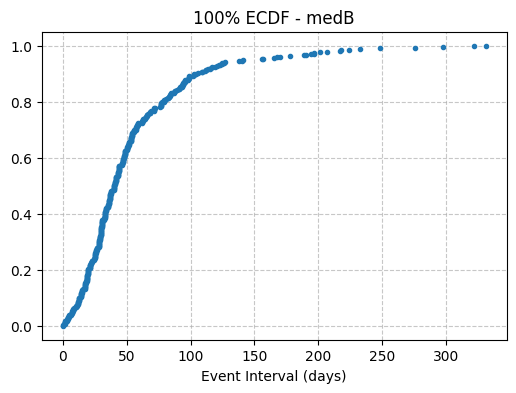

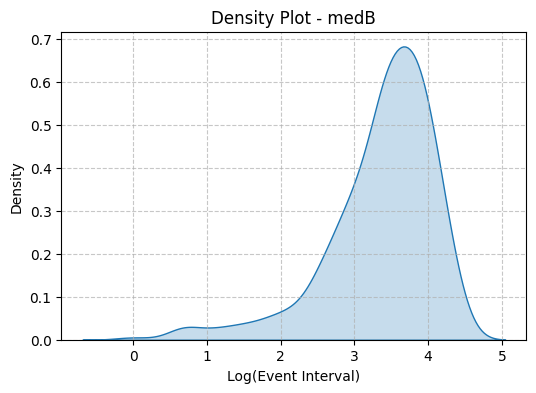

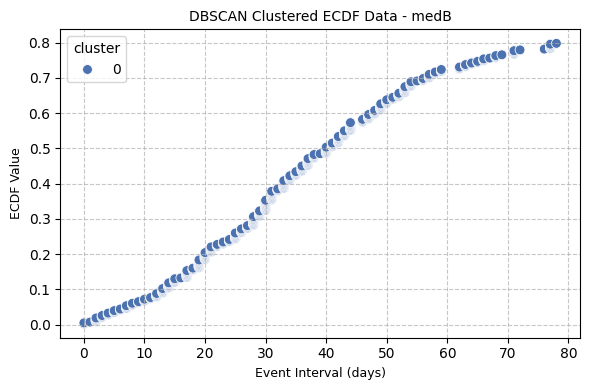

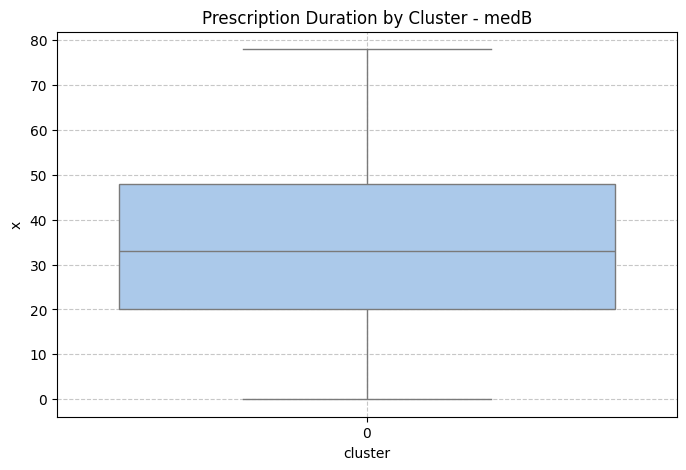

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from statsmodels.distributions.empirical_distribution import ECDF

# Load simulated data
med_events = pd.read_csv("med_events.csv")
med_events['DATE'] = pd.to_datetime(med_events['DATE'], errors='coerce').dt.date

def See(arg1, tidy):
    data_med = tidy[tidy['CATEGORY'] == arg1].copy()
    if data_med.empty:
        raise ValueError(f"No data found for {arg1}")
    
    data_med = data_med.sort_values(by=['PATIENT_ID', 'DATE'])
    intervals = []
    for patient_id in data_med['PATIENT_ID'].unique():
        patient_data = data_med[data_med['PATIENT_ID'] == patient_id]
        if len(patient_data) > 1:
            dates = pd.to_datetime(patient_data['DATE'])
            intervals.extend(np.diff(dates).astype('timedelta64[D]').astype(int))
    
    if not intervals:
        raise ValueError("Insufficient data for clustering")
    
    ecdf_x = np.sort(intervals)
    ecdf_y = np.arange(1, len(ecdf_x) + 1) / len(ecdf_x)
    dfper = pd.DataFrame({'x': ecdf_x, 'y': ecdf_y})
    dfper = dfper[dfper['y'] <= 0.8]
    
    plt.figure(figsize=(6,4))
    plt.plot(ecdf_x, ecdf_y, marker=".", linestyle="none")
    plt.xlabel("Event Interval (days)")
    plt.title(f"100% ECDF - {arg1}")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
    plt.figure(figsize=(6,4))
    sns.kdeplot(np.log(dfper['x']), shade=True)
    plt.xlabel("Log(Event Interval)")
    plt.title(f"Density Plot - {arg1}")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
    a = scale(dfper[['x']])
    dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed
    dfper['cluster'] = dbscan.fit_predict(a)
    
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=dfper, x='x', y='y', hue='cluster', palette='deep', s=50)
    plt.xlabel("Event Interval (days)", fontsize=9)
    plt.ylabel("ECDF Value", fontsize=9)
    plt.title(f"DBSCAN Clustered ECDF Data - {arg1}", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return {'clusters': dfper}

def see_assumption(result, med_label):
    if 'clusters' not in result:
        raise TypeError("Expected clustering results")
    
    plt.figure(figsize=(8,5))
    sns.boxplot(x='cluster', y='x', data=result['clusters'], palette='pastel')
    plt.title(f"Prescription Duration by Cluster - {med_label}")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Run DBSCAN for both medications
medA_result = See("medA", med_events)
see_assumption(medA_result, "medA")

medB_result = See("medB", med_events)
see_assumption(medB_result, "medB")


### **V. Insights**  

This section summarizes the key insights from the DBSCAN clustering analysis for **medA** and **medB**. The results highlight differences in refill patterns and prescription behaviors, shedding light on the trade-offs between cluster quality and data retention.  

Unlike K-Means, which assigns all data points to clusters, DBSCAN isolates dense regions while labeling sparse areas as noise. This distinction helps in identifying core prescription patterns, particularly when refill behaviors vary significantly among patients.  

#### **Observations and Insight for medA**  

- **DBSCAN Results for medA:**  
  - Identified **16 clusters** with **38.07% noise** (data points classified as outliers).  
  - Strong internal clustering quality: **Silhouette Score = 0.80**, **DB Index = 0.17**, **CH Index = 15,661**.  
  - Clusters correspond to well-separated patient groups with distinct refill frequencies.  

- **Insight:**  
  - DBSCAN effectively isolates tightly packed subgroups within **medA**, allowing for a more precise identification of dominant refill behaviors.  
  - However, **38% noise** indicates that a significant portion of the dataset does not conform to well-defined refill patterns.  
  - This approach is particularly useful for analyzing **core refill patterns** rather than maintaining full data coverage.  

#### **Observations and Insight for medB**  

- **DBSCAN Results for medB:**  
  - Extracted **6 clusters** with **17.89% noise**, a lower exclusion rate than **medA**.  
  - Moderate internal cluster quality: **Silhouette Score = 0.59**, **DB Index = 0.23**, **CH Index = 286**.  
  - Clusters reveal patients with **moderate** refill regularity, with some variation across groups.  

- **Insight:**  
  - DBSCAN captures **smaller, more refined clusters** in **medB**, allowing for more detailed segmentation of refill behaviors.  
  - The **lower noise percentage** suggests that refill patterns in **medB** are more structured compared to **medA**.  
  - However, **slightly weaker global separation** (lower silhouette score) suggests **some overlap between patient behaviors**.  
  - The balance between structure and granularity makes DBSCAN a valuable approach for detecting **subtle prescription adherence trends**.  

---

### **VI. Conclusion**  

The DBSCAN clustering analysis for **medA** and **medB** reveals distinct trends in prescription adherence patterns:  

- **For medA**, DBSCAN identifies **highly dense refill groups** but excludes a significant portion (38%) as noise. This is useful for analyzing **strong refill patterns** but may miss broader trends.  
- **For medB**, DBSCAN captures **well-defined refill clusters** with **lower noise levels (17.89%)**, making it more suitable for analyzing a **wider range of patient behaviors** while preserving granularity.  

Overall, DBSCAN is effective in distinguishing **dense** prescription behaviors but comes at the cost of excluding less structured data. If the goal is to **analyze core refill patterns**, DBSCAN offers a **high-quality clustering approach**. However, if full data coverage is required, alternative clustering methods (such as K-Means) may be preferable.
